/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_58104/979314659.py:153: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


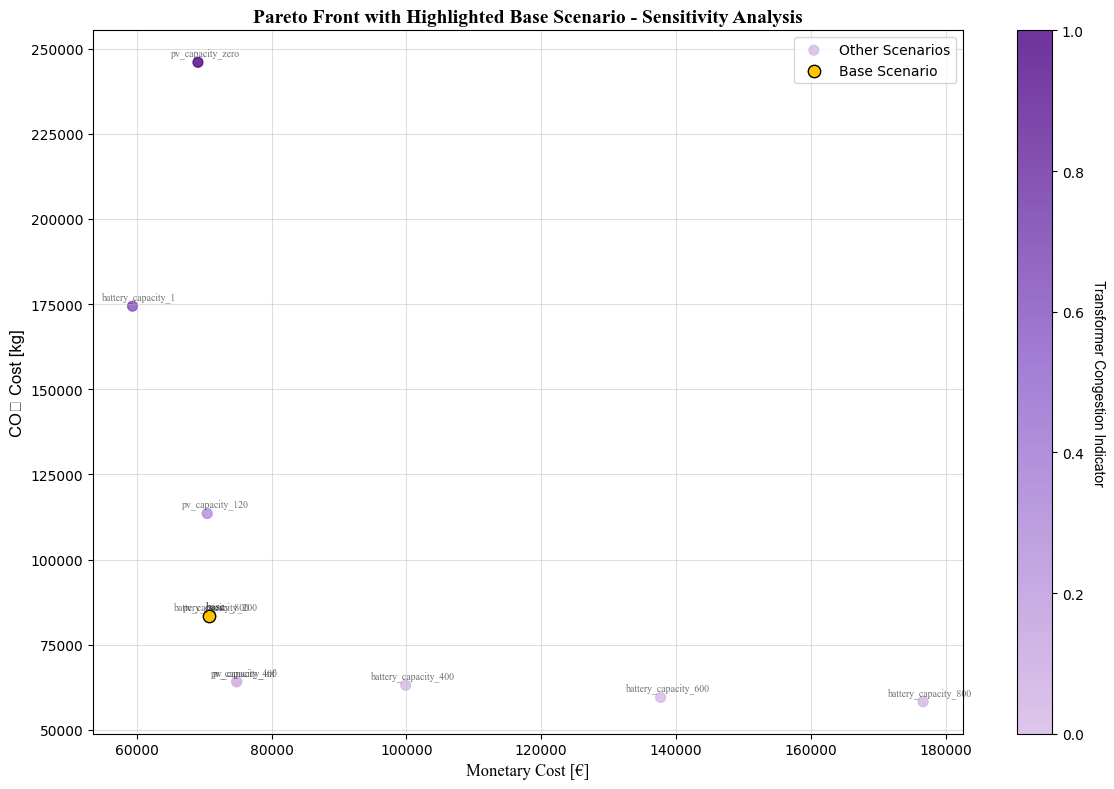

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_structural"

# Verify if the directory exists
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# ----------------------------
# 🛠️ Normalize Transformer Congestion Indicator
# ----------------------------
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Pareto Front with Highlighted Base Scenario
# ----------------------------
plt.figure(figsize=(12, 8))

# Plot all scenarios except 'sensitivity_base'
base_scenario = df_costs[df_costs["scenario"] == "base"]
other_scenarios = df_costs[df_costs["scenario"] != "base"]

# Plot other scenarios
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,  # Dot size
    label="Other Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,  # Slightly larger dot size
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Arial')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Arial', fontsize=12)  # Fallback font for subscript "₂"
plt.title("Pareto Front with Highlighted Base Scenario - Sensitivity Analysis", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    if row['scenario'] == 'base':
        plt.annotate(
            row['scenario'],
            (row['monetary_cost'], row['co2_cost']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=8,
            color='#2C2C2C',
            fontname='Times New Roman'
        )
    else:
        plt.annotate(
            row['scenario'],
            (row['monetary_cost'], row['co2_cost']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=7,
            color='#2C2C2C',
            alpha=0.7,
            fontname='Times New Roman'
        )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_structural"
PARETO_FILE = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs_dirichlet/all_results.csv"

# Verify directories
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

if not os.path.exists(PARETO_FILE):
    raise FileNotFoundError(f"The Pareto results file '{PARETO_FILE}' does not exist.")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Normalize Transformer Congestion Indicator
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 📊 Load Pareto Front Data
# ----------------------------
pareto_data = pd.read_csv(PARETO_FILE)
pareto_data = pareto_data[["monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Filter extreme values
pareto_data = pareto_data[
    (pareto_data["monetary_cost"] <= pareto_data["monetary_cost"].quantile(1)) &
    (pareto_data["co2_cost"] <= pareto_data["co2_cost"].quantile(1)) &
    (pareto_data["transformer_congestion_indicator"] <= pareto_data["transformer_congestion_indicator"].quantile(1))
]

# Normalize Transformer Congestion Indicator for Pareto Front
pareto_data["transformer_congestion_indicator"] = (
    (pareto_data["transformer_congestion_indicator"] - pareto_data["transformer_congestion_indicator"].min()) /
    (pareto_data["transformer_congestion_indicator"].max() - pareto_data["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Combined Pareto Front and Sensitivity Scenarios
# ----------------------------
plt.figure(figsize=(14, 8))

# Plot Pareto Front in background
plt.scatter(
    pareto_data["monetary_cost"],
    pareto_data["co2_cost"],
    c=pareto_data["transformer_congestion_indicator"],
    cmap=accenture_cmap,
    alpha=0.3,
    s=20,
    label="Pareto Front (Historical)"
)

# Plot other scenarios
other_scenarios = df_costs[df_costs["scenario"] != "base"]
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,
    label="Sensitivity Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
base_scenario = df_costs[df_costs["scenario"] == "base"]
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Times New Roman')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Times New Roman', fontsize=12)
plt.title("Pareto Front with Sensitivity Analysis Overlay", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    plt.annotate(
        row['scenario'],
        (row['monetary_cost'], row['co2_cost']),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=7,
        color='#2C2C2C',
        fontname='Times New Roman'
    )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_58104/3301498021.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  plt.tight_layout()
/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_58104/609204096.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  plt.tight_layout()
/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)


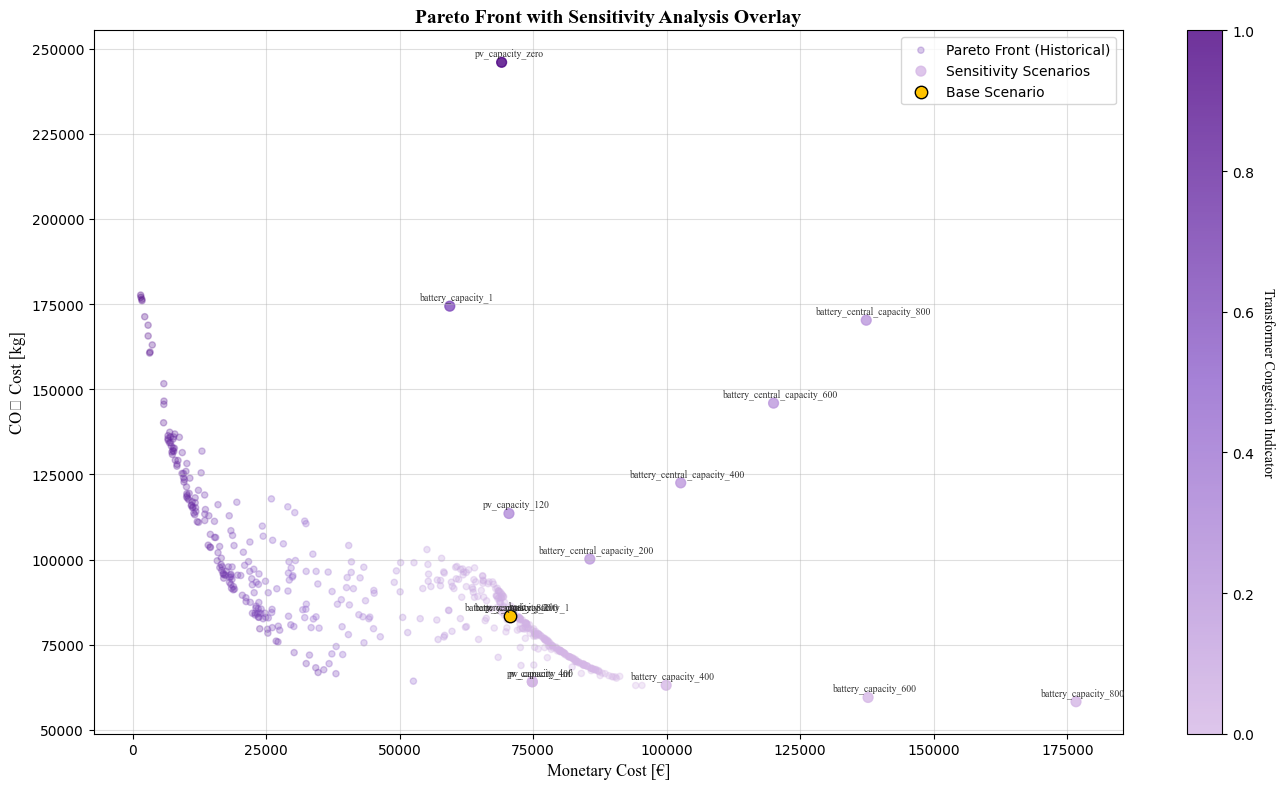

In [20]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_structural_copy"
PARETO_FILE = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs_dirichlet/all_results.csv"

# Verify directories
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

if not os.path.exists(PARETO_FILE):
    raise FileNotFoundError(f"The Pareto results file '{PARETO_FILE}' does not exist.")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Normalize Transformer Congestion Indicator
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 📊 Load Pareto Front Data
# ----------------------------
pareto_data = pd.read_csv(PARETO_FILE)
pareto_data = pareto_data[["monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Filter extreme values
pareto_data = pareto_data[
    (pareto_data["monetary_cost"] <= pareto_data["monetary_cost"].quantile(1)) &
    (pareto_data["co2_cost"] <= pareto_data["co2_cost"].quantile(1)) &
    (pareto_data["transformer_congestion_indicator"] <= pareto_data["transformer_congestion_indicator"].quantile(1))
]

# Normalize Transformer Congestion Indicator for Pareto Front
pareto_data["transformer_congestion_indicator"] = (
    (pareto_data["transformer_congestion_indicator"] - pareto_data["transformer_congestion_indicator"].min()) /
    (pareto_data["transformer_congestion_indicator"].max() - pareto_data["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Combined Pareto Front and Sensitivity Scenarios
# ----------------------------
plt.figure(figsize=(14, 8))

# Plot Pareto Front in background
plt.scatter(
    pareto_data["monetary_cost"],
    pareto_data["co2_cost"],
    c=pareto_data["transformer_congestion_indicator"],
    cmap=accenture_cmap,
    alpha=0.3,
    s=20,
    label="Pareto Front (Historical)"
)

# Plot other scenarios
other_scenarios = df_costs[df_costs["scenario"] != "base"]
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,
    label="Sensitivity Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
base_scenario = df_costs[df_costs["scenario"] == "base"]
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Times New Roman')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Times New Roman', fontsize=12)
plt.title("Pareto Front with Sensitivity Analysis Overlay", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    plt.annotate(
        row['scenario'],
        (row['monetary_cost'], row['co2_cost']),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=7,
        color='#2C2C2C',
        fontname='Times New Roman'
    )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

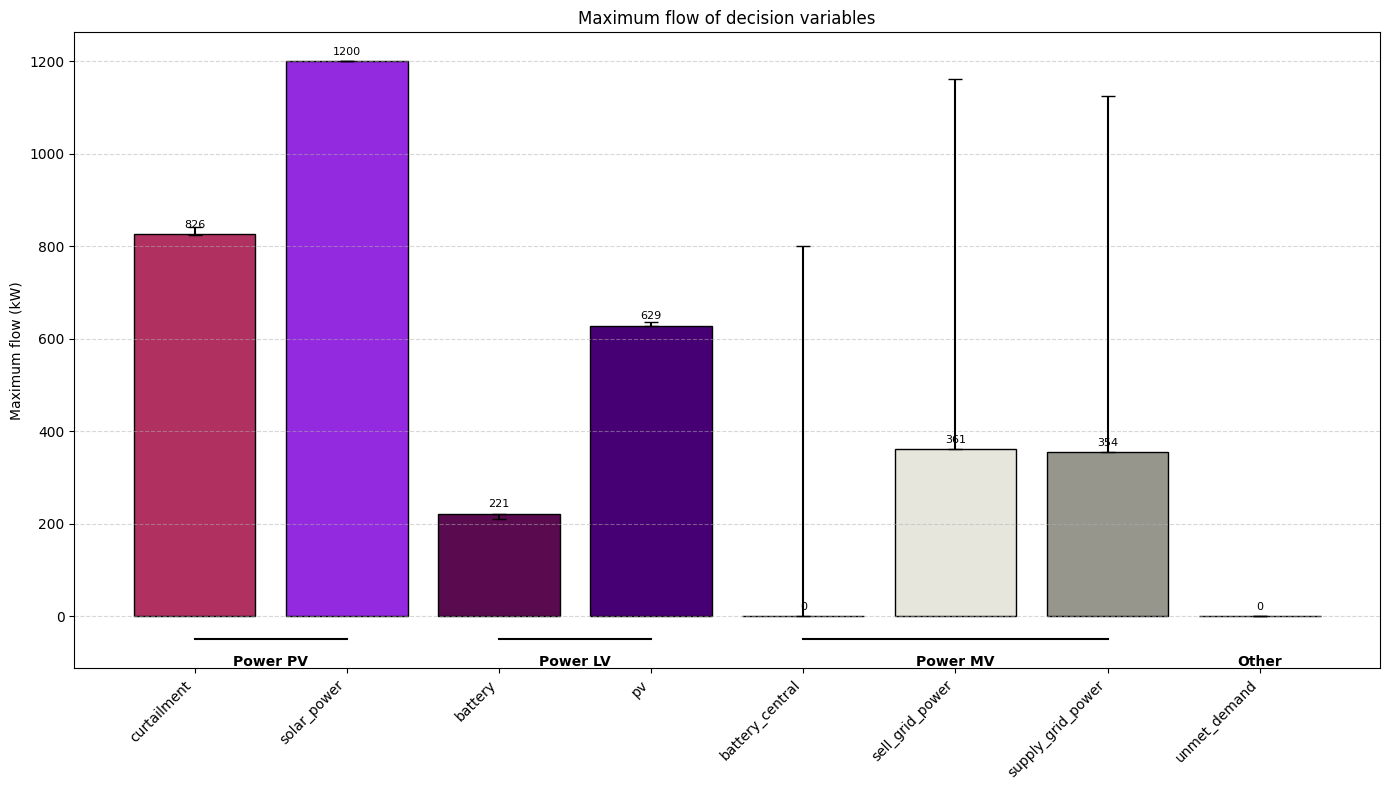

In [28]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_extra"
BASE_SCENARIO = "./sensitivity_analysis_runs_parameter/sensitivity_base.nc"

# Verify if directories exist
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")
if not os.path.exists(BASE_SCENARIO):
    raise FileNotFoundError(f"The base scenario file '{BASE_SCENARIO}' does not exist.")

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
tech_colors = {
    "supply_grid_power": "#96968c",
    "solar_power": "#942adf",
    "unmet_demand": "#d62128",
    "sell_grid_power": "#e6e6dc",
    "curtailment": "#b03060",
    "pv": "#460073",
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f"
}

tech_carriers = {
    "solar_power": "Power PV",
    "curtailment": "Power PV",
    "pv": "Power LV",
    "battery": "Power LV",
    "sell_grid_power": "Power MV",
    "supply_grid_power": "Power MV",
    "battery_central": "Power MV",
    "unmet_demand": "Other"
}

carrier_sort_order = ["Power PV", "Power LV", "Power MV", "Other"]
selected_techs = list(tech_carriers.keys())

# ----------------------------
# 📊 Extract Installed Capacity from NetCDF
# ----------------------------
def extract_installed_capacity(file_path):
    """
    Extract installed capacity per technology from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        df_capacity = (
            model["flow_cap"]
            .sum(dim="nodes")
            .to_dataframe(name="installed_capacity")
            .reset_index()
        )

        # Check if 'techs' column exists
        if "techs" not in df_capacity.columns:
            raise KeyError(f"Column 'techs' not found in file: {file_path}")

        # Handle PV double counting
        if "pv" in df_capacity["techs"].values:
            df_capacity.loc[df_capacity["techs"] == "pv", "installed_capacity"] /= 2

        # Filter for selected technologies
        df_capacity = df_capacity[df_capacity["techs"].isin(selected_techs)]

        # Aggregate by technology
        df_capacity = df_capacity.groupby("techs", as_index=False).agg({"installed_capacity": "sum"})

        return df_capacity
    except KeyError as e:
        print(f"[ERROR] {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return pd.DataFrame()

# ----------------------------
# 📑 Aggregate Base Scenario and Sensitivity Scenarios
# ----------------------------
# Base scenario
df_base = extract_installed_capacity(BASE_SCENARIO)
if df_base.empty:
    raise ValueError("Base scenario processing failed or contains no valid data.")

df_base["carrier"] = df_base["techs"].map(tech_carriers).fillna("Other")

# Sensitivity scenarios
sensitivity_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc') and f != os.path.basename(BASE_SCENARIO)]
sensitivity_data = []

for scenario_file in sensitivity_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    df_sensitivity = extract_installed_capacity(scenario_path)
    if df_sensitivity.empty:
        print(f"[SKIPPED] No valid data for file: {scenario_file}")
        continue
    df_sensitivity["carrier"] = df_sensitivity["techs"].map(tech_carriers).fillna("Other")
    sensitivity_data.append(df_sensitivity)

# Combine all sensitivity data
if not sensitivity_data:
    raise ValueError("No valid sensitivity data found.")
df_sensitivity_combined = pd.concat(sensitivity_data, ignore_index=True)

# Calculate variance (min and max installed capacity per tech)
df_variance = df_sensitivity_combined.groupby("techs")["installed_capacity"].agg(["min", "max"]).reset_index()

# Merge with base scenario
df_plot = pd.merge(df_base, df_variance, on="techs", how="left")

# Ensure no NaN in variance columns
df_plot['min'] = df_plot['min'].fillna(df_plot['installed_capacity'])
df_plot['max'] = df_plot['max'].fillna(df_plot['installed_capacity'])

# ----------------------------
# 📊 Sorting by Carrier
# ----------------------------
df_plot["carrier"] = df_plot["techs"].map(tech_carriers).fillna("Other")
df_plot["carrier_order"] = df_plot["carrier"].apply(lambda x: carrier_sort_order.index(x))
df_plot = df_plot.sort_values(by=["carrier_order", "techs"]).reset_index(drop=True)

# ----------------------------
# 📊 Plotting with Carrier Brackets
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

x_positions = np.arange(len(df_plot))

# Plot technologies with variance
for i, row in df_plot.iterrows():
    tech = row['techs']
    base_capacity = row['installed_capacity']
    min_capacity = row['min']
    max_capacity = row['max']

    # Ensure yerr values are non-negative
    lower_error = max(0, base_capacity - min_capacity)
    upper_error = max(0, max_capacity - base_capacity)

    # Bar plot for base capacity
    ax.bar(
        x_positions[i],
        base_capacity,
        color=tech_colors.get(tech, "#cccccc"),
        edgecolor="black"
    )

    # Error bars
    ax.errorbar(
        x_positions[i],
        base_capacity,
        yerr=[[lower_error], [upper_error]],
        fmt='none',
        ecolor='black',
        capsize=5,
        capthick=1
    )

    # Annotate base capacity value
    ax.text(
        x_positions[i],
        base_capacity + 10,
        f"{base_capacity:.0f}",
        ha='center',
        va='bottom',
        fontsize=8
    )

# Grouping Technologies with Brackets
for carrier in carrier_sort_order:
    indices = df_plot[df_plot["carrier"] == carrier].index.tolist()
    if indices:
        ax.plot(
            [indices[0], indices[-1]],
            [-50, -50],
            color='black'
        )
        ax.text(
            (indices[0] + indices[-1]) / 2,
            -100,
            carrier,
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold'
        )

ax.set_xticks(x_positions)
ax.set_xticklabels(df_plot["techs"], rotation=45, ha="right")
ax.set_ylabel('Maximum flow (kW)')
ax.set_title('Maximum flow of decision variables')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

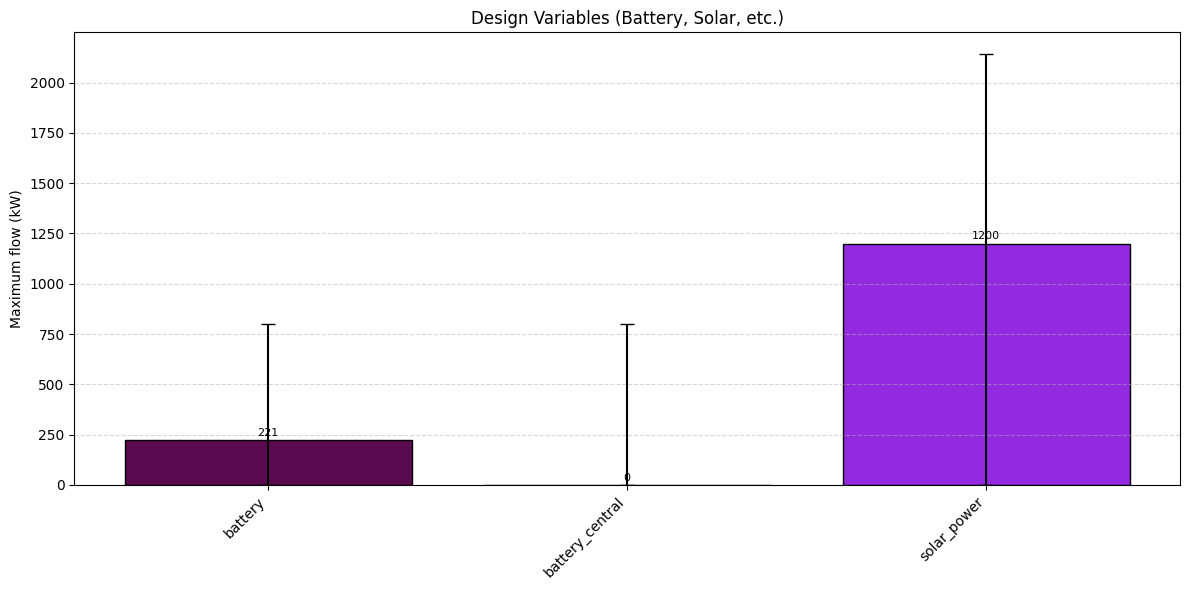

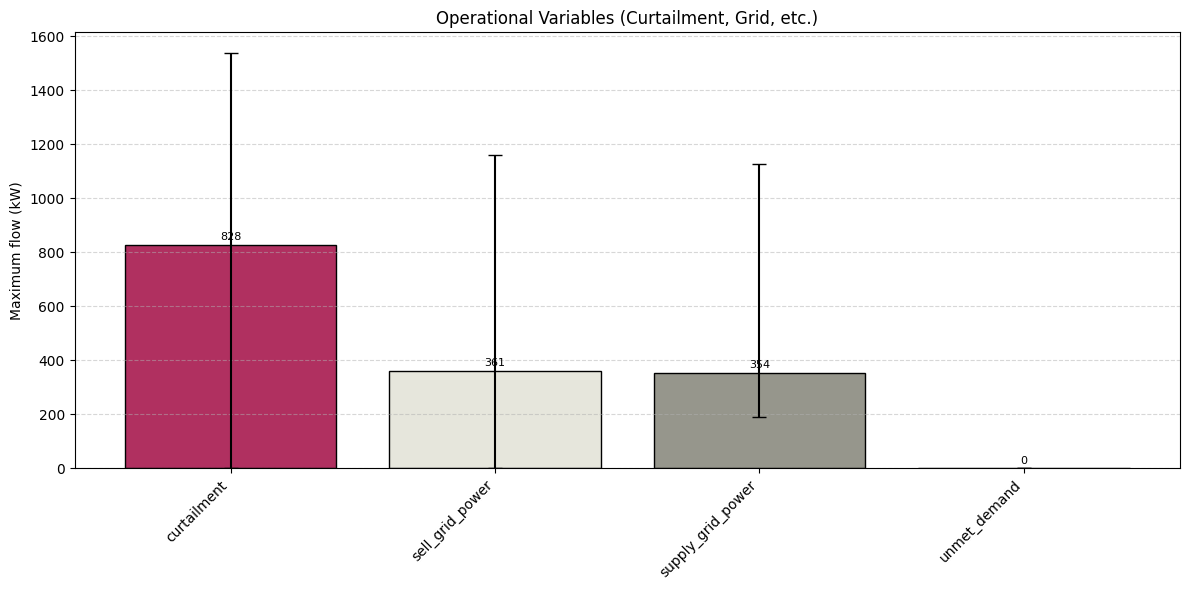

In [31]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_structural_copy"
BASE_SCENARIO = "./sensitivity_analysis_runs_structural_copy/sensitivity_base.nc"

# Verify if directories exist
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")
if not os.path.exists(BASE_SCENARIO):
    raise FileNotFoundError(f"The base scenario file '{BASE_SCENARIO}' does not exist.")

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
tech_colors = {
    "supply_grid_power": "#96968c",
    "solar_power": "#942adf",
    "unmet_demand": "#d62128",
    "sell_grid_power": "#e6e6dc",
    "curtailment": "#b03060",
    "pv": "#460073",
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f"
}

design_variables = ["battery", "battery_central", "solar_power"]
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

tech_carriers = {
    "solar_power": "Power PV",
    "curtailment": "Power PV",
    "pv": "Power LV",
    "battery": "Power LV",
    "sell_grid_power": "Power MV",
    "supply_grid_power": "Power MV",
    "battery_central": "Power MV",
    "unmet_demand": "Other"
}

selected_techs = list(tech_carriers.keys())

# ----------------------------
# 📊 Extract Installed Capacity from NetCDF
# ----------------------------
def extract_installed_capacity(file_path):
    """
    Extract installed capacity per technology from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        df_capacity = (
            model["flow_cap"]
            .sum(dim="nodes")
            .to_dataframe(name="installed_capacity")
            .reset_index()
        )

        # Check if 'techs' column exists
        if "techs" not in df_capacity.columns:
            raise KeyError(f"Column 'techs' not found in file: {file_path}")

        # Handle PV double counting
        if "pv" in df_capacity["techs"].values:
            df_capacity.loc[df_capacity["techs"] == "pv", "installed_capacity"] /= 2

        # Filter for selected technologies
        df_capacity = df_capacity[df_capacity["techs"].isin(selected_techs)]

        # Remove duplicate technologies, keep the first occurrence
        df_capacity = df_capacity.groupby("techs", as_index=False).agg({"installed_capacity": "sum"})

        return df_capacity
    except KeyError as e:
        print(f"[ERROR] {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return pd.DataFrame()

# ----------------------------
# 📑 Aggregate Base Scenario and Sensitivity Scenarios
# ----------------------------
# Base scenario
df_base = extract_installed_capacity(BASE_SCENARIO)
if df_base.empty:
    raise ValueError("Base scenario processing failed or contains no valid data.")

# Sensitivity scenarios
sensitivity_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc') and f != os.path.basename(BASE_SCENARIO)]
sensitivity_data = []

for scenario_file in sensitivity_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    df_sensitivity = extract_installed_capacity(scenario_path)
    if df_sensitivity.empty:
        print(f"[SKIPPED] No valid data for file: {scenario_file}")
        continue
    sensitivity_data.append(df_sensitivity)

# Combine all sensitivity data
if not sensitivity_data:
    raise ValueError("No valid sensitivity data found.")
df_sensitivity_combined = pd.concat(sensitivity_data, ignore_index=True)

# Calculate variance (min and max installed capacity per tech)
df_variance = df_sensitivity_combined.groupby("techs")["installed_capacity"].agg(["min", "max"]).reset_index()

# Merge with base scenario
df_plot = pd.merge(df_base, df_variance, on="techs", how="left")

# Ensure no NaN in variance columns
df_plot['min'] = df_plot['min'].fillna(df_plot['installed_capacity'])
df_plot['max'] = df_plot['max'].fillna(df_plot['installed_capacity'])

# ----------------------------
# 📊 Plotting
# ----------------------------
def plot_variables(df, variable_list, title):
    """
    Plot bar chart for given variable list.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Filter data for the specified variables
    df_filtered = df[df["techs"].isin(variable_list)].reset_index(drop=True)
    x_positions = np.arange(len(df_filtered))

    for i, row in df_filtered.iterrows():
        tech = row["techs"]
        base_capacity = row["installed_capacity"]
        min_capacity = row["min"]
        max_capacity = row["max"]

        # Ensure yerr values are non-negative
        lower_error = max(0, base_capacity - min_capacity)
        upper_error = max(0, max_capacity - base_capacity)

        # Bar plot for base capacity
        ax.bar(
            x_positions[i],
            base_capacity,
            color=tech_colors.get(tech, "#cccccc"),
            edgecolor="black"
        )

        # Error bars
        ax.errorbar(
            x_positions[i],
            base_capacity,
            yerr=[[lower_error], [upper_error]],
            fmt='none',
            ecolor='black',
            capsize=5,
            capthick=1
        )

        # Annotate base capacity value
        ax.text(
            x_positions[i],
            base_capacity + 10,
            f"{base_capacity:.0f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

    # Aesthetics
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_filtered["techs"], rotation=45, ha="right")
    ax.set_ylabel("Maximum flow (kW)")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot Design Variables
plot_variables(df_plot, design_variables, "Design Variables (Battery, Solar, etc.)")

# Plot Operational Variables
plot_variables(df_plot, operational_variables, "Operational Variables (Curtailment, Grid, etc.)")

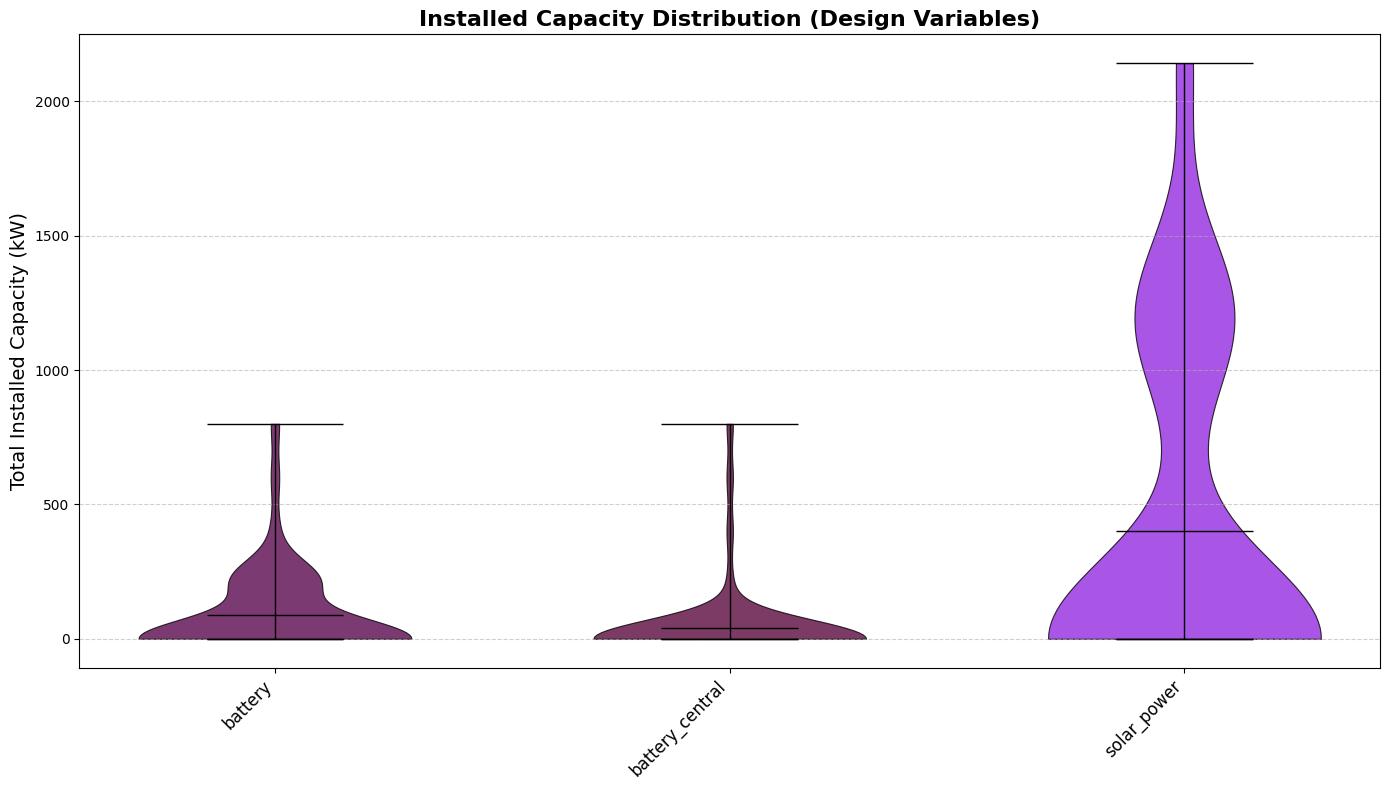

In [16]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Paths and Directories
SCENARIO_DIR = "./sensitivity_analysis_runs_structural_copy"
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist.")

# Visualization Settings
tech_colors = {
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f",
    "solar_power": "#942adf",
    "curtailment": "#b03060",
    "sell_grid_power": "#e6e6dc",
    "supply_grid_power": "#96968c",
    "unmet_demand": "#d62128"
}
design_variables = ["battery", "battery_central", "solar_power"]
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

# Extract Total Flow Cap
def extract_total_flow_cap(directory, variable="flow_cap"):
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    for file in files:
        try:
            model = xr.open_dataset(file)
            
            # Ensure the variable exists
            if variable not in model.variables:
                print(f"[SKIPPED] '{variable}' not found in {file}")
                continue
            
            # Align dimensions to prevent mismatch
            flow_cap = model[variable]
            if "techs" in flow_cap.dims and "nodes" in flow_cap.dims:
                flow_cap = flow_cap.sum(dim="nodes")
                flow_cap_df = flow_cap.to_dataframe(name="total_installed_capacity").reset_index()

                # Align with techs dimension
                if "techs" in model.coords:
                    techs = model["techs"].values
                    flow_cap_df = flow_cap_df[flow_cap_df["techs"].isin(techs)]
                else:
                    print(f"[WARNING] 'techs' coordinate not found in {file}.")
                    continue

                # Append scenario name
                flow_cap_df["scenario"] = os.path.basename(file)
                data.append(flow_cap_df)
            else:
                print(f"[ERROR] '{file}' does not have the required dimensions ('techs', 'nodes').")
        except Exception as e:
            print(f"[ERROR] {file}: {e}")

    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

# Extract Data
df_total = extract_total_flow_cap(SCENARIO_DIR)
if df_total.empty:
    raise ValueError("No valid data found.")

# Filter Design and Operational Variables
df_design = df_total[df_total["techs"].isin(design_variables)]
df_operational = df_total[df_total["techs"].isin(operational_variables)]

# Improved Violin Plot Function
def plot_violin(data, title, ylabel):
    """
    Enhanced violin plot with a professional aesthetic.
    """
    if data.empty:
        print(f"[WARNING] No data available for {title.lower()}.")
        return

    techs = sorted(data["techs"].unique(), key=lambda x: design_variables.index(x) if x in design_variables else operational_variables.index(x))
    positions = range(len(techs))
    colors = [tech_colors.get(tech, "#cccccc") for tech in techs]

    plt.figure(figsize=(14, 8))

    # Collect data for each tech
    datasets = [data[data["techs"] == tech]["total_installed_capacity"].values for tech in techs]

    # Create violin plots
    violins = plt.violinplot(
        datasets,
        positions=positions,
        showmeans=True,
        showmedians=True,
        widths=0.6
    )

    # Custom colors and transparency for violins
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
        body.set_alpha(0.8)
        body.set_edgecolor('black')
        body.set_linewidth(0.8)

    # Customizing other parts of the violin
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
        vp = violins[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    # Aesthetics
    plt.xticks(positions, techs, rotation=45, ha="right", fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot Design Variables
plot_violin(df_design, "Installed Capacity Distribution (Design Variables)", "Total Installed Capacity (kW)")

# Plot Operational Variables
plot_violin(df_operational, "Installed Capacity Distribution (Operational Variables)", "Total Installed Capacity (kW)")

Parameter

[ERROR] Missing required variable in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timest

/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_58104/1742811901.py:153: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


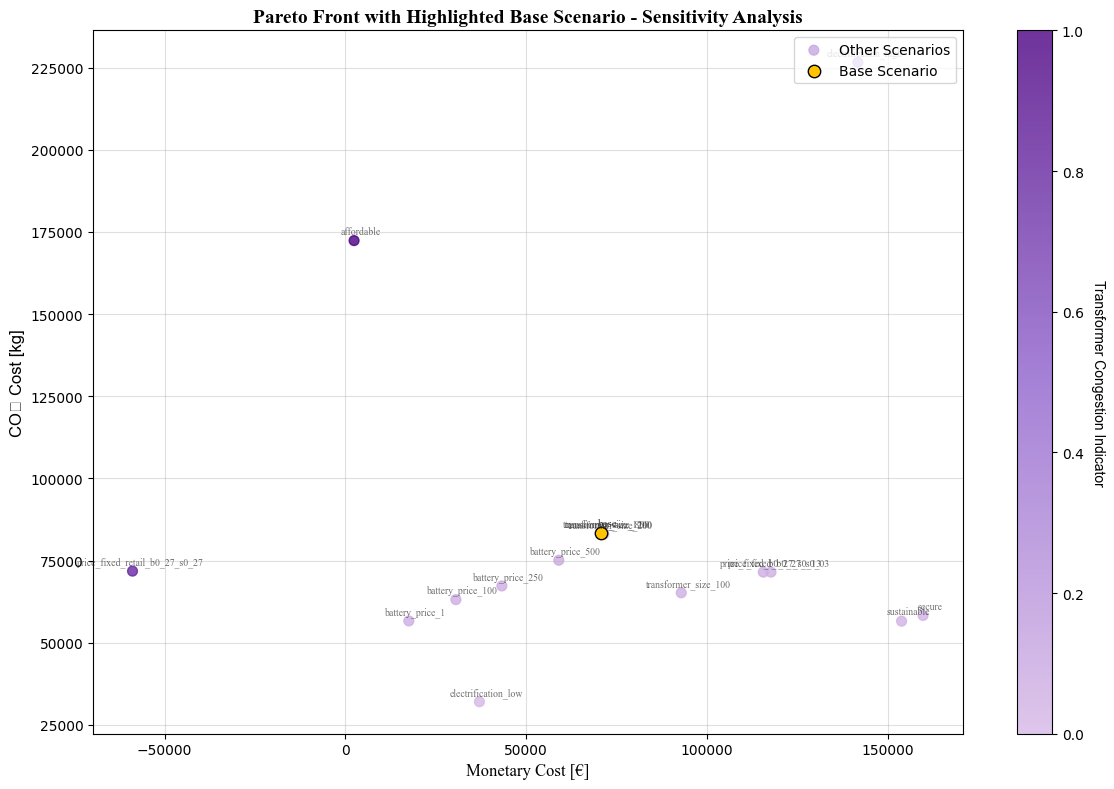

In [15]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"

# Verify if the directory exists
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# ----------------------------
# 🛠️ Normalize Transformer Congestion Indicator
# ----------------------------
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Pareto Front with Highlighted Base Scenario
# ----------------------------
plt.figure(figsize=(12, 8))

# Plot all scenarios except 'sensitivity_base'
base_scenario = df_costs[df_costs["scenario"] == "base"]
other_scenarios = df_costs[df_costs["scenario"] != "base"]

# Plot other scenarios
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,  # Dot size
    label="Other Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,  # Slightly larger dot size
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Arial')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Arial', fontsize=12)  # Fallback font for subscript "₂"
plt.title("Pareto Front with Highlighted Base Scenario - Sensitivity Analysis", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    if row['scenario'] == 'base':
        plt.annotate(
            row['scenario'],
            (row['monetary_cost'], row['co2_cost']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=8,
            color='#2C2C2C',
            fontname='Times New Roman'
        )
    else:
        plt.annotate(
            row['scenario'],
            (row['monetary_cost'], row['co2_cost']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=7,
            color='#2C2C2C',
            alpha=0.7,
            fontname='Times New Roman'
        )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"
PARETO_FILE = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/Experiments/pareto_fronts/pareto_front_runs_dirichlet/all_results.csv"

# Verify directories
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")

if not os.path.exists(PARETO_FILE):
    raise FileNotFoundError(f"The Pareto results file '{PARETO_FILE}' does not exist.")

# ----------------------------
# 📊 Extract Costs from NetCDF Files
# ----------------------------
def extract_costs_from_netcdf(file_path):
    """
    Extract monetary, CO2, and transformer congestion costs from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        monetary_cost = model['cost'].sel(costs='monetary').sum().values.item()
        co2_cost = model['cost'].sel(costs='co2_emissions').sum().values.item()
        transformer_cost = model['cost'].sel(costs='transformer_congestion_indicator').sum().values.item()
        
        return {
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost
        }
    except KeyError as e:
        print(f"[ERROR] Missing required variable in {file_path}: {e}")
        return None
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return None


# ----------------------------
# 📑 Aggregate Costs from All Scenarios
# ----------------------------
scenario_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc')]
cost_data = []

for scenario_file in scenario_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    scenario_name = os.path.splitext(scenario_file)[0].replace('sensitivity_', '')  # Remove 'sensitivity_'
    costs = extract_costs_from_netcdf(scenario_path)
    
    if costs:
        costs["scenario"] = scenario_name  # Add clean scenario name to the data
        cost_data.append(costs)

# Create DataFrame
if not cost_data:
    raise ValueError("No valid cost data found in the NetCDF files.")

df_costs = pd.DataFrame(cost_data)

# Reorder columns for clarity
df_costs = df_costs[["scenario", "monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Normalize Transformer Congestion Indicator
df_costs["transformer_congestion_indicator"] = (
    (df_costs["transformer_congestion_indicator"] - df_costs["transformer_congestion_indicator"].min()) /
    (df_costs["transformer_congestion_indicator"].max() - df_costs["transformer_congestion_indicator"].min())
)

# ----------------------------
# 📊 Load Pareto Front Data
# ----------------------------
pareto_data = pd.read_csv(PARETO_FILE)
pareto_data = pareto_data[["monetary_cost", "co2_cost", "transformer_congestion_indicator"]]

# Normalize Transformer Congestion Indicator for Pareto Front
pareto_data["transformer_congestion_indicator"] = (
    (pareto_data["transformer_congestion_indicator"] - pareto_data["transformer_congestion_indicator"].min()) /
    (pareto_data["transformer_congestion_indicator"].max() - pareto_data["transformer_congestion_indicator"].min())
)

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
accenture_cmap = LinearSegmentedColormap.from_list(
    "accenture", ["#D6B8E6", "#9063CD", "#4B0082"]
)

# ----------------------------
# 📊 Plot Combined Pareto Front and Sensitivity Scenarios
# ----------------------------
plt.figure(figsize=(14, 8))

# Plot Pareto Front in background
plt.scatter(
    pareto_data["monetary_cost"],
    pareto_data["co2_cost"],
    c=pareto_data["transformer_congestion_indicator"],
    cmap=accenture_cmap,
    alpha=0.3,
    s=20,
    label="Pareto Front (Historical)"
)

# Plot other scenarios
other_scenarios = df_costs[df_costs["scenario"] != "base"]
scatter = plt.scatter(
    other_scenarios["monetary_cost"],
    other_scenarios["co2_cost"],
    c=other_scenarios["transformer_congestion_indicator"],  # Color by transformer congestion
    cmap=accenture_cmap,
    alpha=0.8,
    s=50,
    label="Sensitivity Scenarios"
)

# Highlight the 'sensitivity_base' scenario in gold/yellow
base_scenario = df_costs[df_costs["scenario"] == "base"]
if not base_scenario.empty:
    plt.scatter(
        base_scenario["monetary_cost"],
        base_scenario["co2_cost"],
        color="#FFC300",  # Accenture Gold
        edgecolor="black",
        alpha=1,
        s=80,
        label="Base Scenario"
    )

# Add color bar for transformer congestion indicator
cbar = plt.colorbar(scatter)
cbar.set_label("Transformer Congestion Indicator", rotation=270, labelpad=15, fontname='Times New Roman')

# Set plot labels and title
plt.xlabel("Monetary Cost [€]", fontname='Times New Roman', fontsize=12)
plt.ylabel("CO₂ Cost [kg]", fontname='Times New Roman', fontsize=12)
plt.title("Pareto Front with Sensitivity Analysis Overlay", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Add clean scenario names as annotations
for i, row in df_costs.iterrows():
    plt.annotate(
        row['scenario'],
        (row['monetary_cost'], row['co2_cost']),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=7,
        color='#2C2C2C',
        fontname='Times New Roman'
    )

# Add legend
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Improve layout
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()

[ERROR] Missing required variable in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[ERROR] Missing required variable in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc: "No variable named 'cost'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timest

/var/folders/hw/y4klzjqd4r9b2k9kpqcs_qth0000gn/T/ipykernel_58104/1636467212.py:163: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  plt.tight_layout()
/Users/tomdebruin/miniforge3/envs/calliope/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)


[ERROR] "No variable named 'flow_cap'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[SKIPPED] No valid data for file: sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc
[ERROR] "No variable named 'flow_cap'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[SKIPPED] No valid data for file: sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc
[ERROR] "No variable named 'flow_cap'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[SKIPPED] No valid data for file: sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc


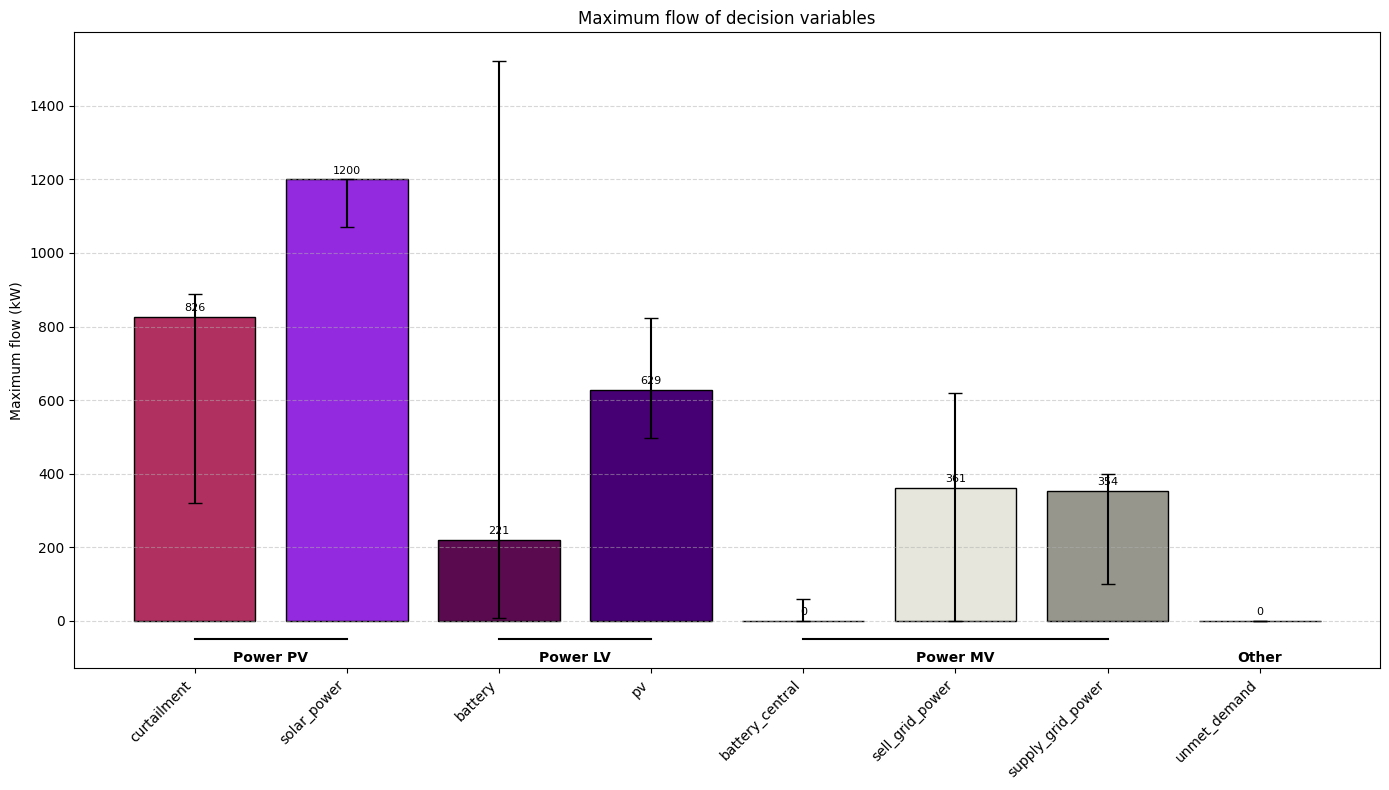

In [24]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"
BASE_SCENARIO = "./sensitivity_analysis_runs_parameter/sensitivity_base.nc"

# Verify if directories exist
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")
if not os.path.exists(BASE_SCENARIO):
    raise FileNotFoundError(f"The base scenario file '{BASE_SCENARIO}' does not exist.")

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
tech_colors = {
    "supply_grid_power": "#96968c",
    "solar_power": "#942adf",
    "unmet_demand": "#d62128",
    "sell_grid_power": "#e6e6dc",
    "curtailment": "#b03060",
    "pv": "#460073",
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f"
}

tech_carriers = {
    "solar_power": "Power PV",
    "curtailment": "Power PV",
    "pv": "Power LV",
    "battery": "Power LV",
    "sell_grid_power": "Power MV",
    "supply_grid_power": "Power MV",
    "battery_central": "Power MV",
    "unmet_demand": "Other"
}

carrier_sort_order = ["Power PV", "Power LV", "Power MV", "Other"]
selected_techs = list(tech_carriers.keys())

# ----------------------------
# 📊 Extract Installed Capacity from NetCDF
# ----------------------------
def extract_installed_capacity(file_path):
    """
    Extract installed capacity per technology from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        df_capacity = (
            model["flow_cap"]
            .sum(dim="nodes")
            .to_dataframe(name="installed_capacity")
            .reset_index()
        )

        # Check if 'techs' column exists
        if "techs" not in df_capacity.columns:
            raise KeyError(f"Column 'techs' not found in file: {file_path}")

        # Handle PV double counting
        if "pv" in df_capacity["techs"].values:
            df_capacity.loc[df_capacity["techs"] == "pv", "installed_capacity"] /= 2

        # Filter for selected technologies
        df_capacity = df_capacity[df_capacity["techs"].isin(selected_techs)]

        # Remove duplicate technologies, keep the first occurrence
        df_capacity = df_capacity.groupby("techs", as_index=False).agg({"installed_capacity": "sum"})

        return df_capacity
    except KeyError as e:
        print(f"[ERROR] {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return pd.DataFrame()

# ----------------------------
# 📑 Aggregate Base Scenario and Sensitivity Scenarios
# ----------------------------
# Base scenario
df_base = extract_installed_capacity(BASE_SCENARIO)
if df_base.empty:
    raise ValueError("Base scenario processing failed or contains no valid data.")

df_base["carrier"] = df_base["techs"].map(tech_carriers).fillna("Other")

# Sensitivity scenarios
sensitivity_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc') and f != os.path.basename(BASE_SCENARIO)]
sensitivity_data = []

for scenario_file in sensitivity_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    df_sensitivity = extract_installed_capacity(scenario_path)
    if df_sensitivity.empty:
        print(f"[SKIPPED] No valid data for file: {scenario_file}")
        continue
    df_sensitivity["carrier"] = df_sensitivity["techs"].map(tech_carriers).fillna("Other")
    sensitivity_data.append(df_sensitivity)

# Combine all sensitivity data
if not sensitivity_data:
    raise ValueError("No valid sensitivity data found.")
df_sensitivity_combined = pd.concat(sensitivity_data, ignore_index=True)

# Calculate variance (min and max installed capacity per tech)
df_variance = df_sensitivity_combined.groupby("techs")["installed_capacity"].agg(["min", "max"]).reset_index()

# Merge with base scenario
df_plot = pd.merge(df_base, df_variance, on="techs", how="left")

# Ensure no NaN in variance columns
df_plot['min'] = df_plot['min'].fillna(df_plot['installed_capacity'])
df_plot['max'] = df_plot['max'].fillna(df_plot['installed_capacity'])

# ----------------------------
# 📊 Sorting by Carrier
# ----------------------------
df_plot["carrier"] = df_plot["techs"].map(tech_carriers).fillna("Other")
df_plot["carrier_order"] = df_plot["carrier"].apply(lambda x: carrier_sort_order.index(x))
df_plot = df_plot.sort_values(by=["carrier_order", "techs"]).reset_index(drop=True)

# ----------------------------
# 📊 Plotting with Carrier Brackets
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

x_positions = np.arange(len(df_plot))

# Plot technologies with variance
for i, row in df_plot.iterrows():
    tech = row['techs']
    base_capacity = row['installed_capacity']
    min_capacity = row['min']
    max_capacity = row['max']

    ax.bar(
        x_positions[i],
        base_capacity,
        color=tech_colors.get(tech, "#cccccc"),
        edgecolor="black"
    )

    ax.errorbar(
        x_positions[i],
        base_capacity,
        yerr=[[base_capacity - min_capacity], [max_capacity - base_capacity]],
        fmt='none',
        ecolor='black',
        capsize=5,
        capthick=1
    )

    ax.text(
        x_positions[i],
        base_capacity + 10,
        f"{base_capacity:.0f}",
        ha='center',
        va='bottom',
        fontsize=8
    )

# Grouping Technologies with Brackets
for carrier in carrier_sort_order:
    indices = df_plot[df_plot["carrier"] == carrier].index.tolist()
    if indices:
        ax.plot(
            [indices[0], indices[-1]],
            [-50, -50],
            color='black'
        )
        ax.text(
            (indices[0] + indices[-1]) / 2,
            -100,
            carrier,
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold'
        )

ax.set_xticks(x_positions)
ax.set_xticklabels(df_plot["techs"], rotation=45, ha="right")
ax.set_ylabel('Maximum flow (kW)')
ax.set_title('Maximum flow of decision variables')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"
BASE_SCENARIO = "./sensitivity_analysis_runs_parameter/sensitivity_base.nc"

# Verify if directories exist
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Run scenarios first!")
if not os.path.exists(BASE_SCENARIO):
    raise FileNotFoundError(f"The base scenario file '{BASE_SCENARIO}' does not exist.")

# ----------------------------
# 🎨 Visualization Settings
# ----------------------------
tech_colors = {
    "supply_grid_power": "#96968c",
    "solar_power": "#942adf",
    "unmet_demand": "#d62128",
    "sell_grid_power": "#e6e6dc",
    "curtailment": "#b03060",
    "pv": "#460073",
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f"
}

design_variables = ["battery", "battery_central", "solar_power"]
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

tech_carriers = {
    "solar_power": "Power PV",
    "curtailment": "Power PV",
    "pv": "Power LV",
    "battery": "Power LV",
    "sell_grid_power": "Power MV",
    "supply_grid_power": "Power MV",
    "battery_central": "Power MV",
    "unmet_demand": "Other"
}

selected_techs = list(tech_carriers.keys())

# ----------------------------
# 📊 Extract Installed Capacity from NetCDF
# ----------------------------
def extract_installed_capacity(file_path):
    """
    Extract installed capacity per technology from a NetCDF file.
    """
    try:
        model = xr.open_dataset(file_path)
        df_capacity = (
            model["flow_cap"]
            .sum(dim="nodes")
            .to_dataframe(name="installed_capacity")
            .reset_index()
        )

        # Check if 'techs' column exists
        if "techs" not in df_capacity.columns:
            raise KeyError(f"Column 'techs' not found in file: {file_path}")

        # Handle PV double counting
        if "pv" in df_capacity["techs"].values:
            df_capacity.loc[df_capacity["techs"] == "pv", "installed_capacity"] /= 2

        # Filter for selected technologies
        df_capacity = df_capacity[df_capacity["techs"].isin(selected_techs)]

        # Remove duplicate technologies, keep the first occurrence
        df_capacity = df_capacity.groupby("techs", as_index=False).agg({"installed_capacity": "sum"})

        return df_capacity
    except KeyError as e:
        print(f"[ERROR] {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"[ERROR] Failed to process {file_path}: {e}")
        return pd.DataFrame()

# ----------------------------
# 📑 Aggregate Base Scenario and Sensitivity Scenarios
# ----------------------------
# Base scenario
df_base = extract_installed_capacity(BASE_SCENARIO)
if df_base.empty:
    raise ValueError("Base scenario processing failed or contains no valid data.")

# Sensitivity scenarios
sensitivity_files = [f for f in os.listdir(SCENARIO_DIR) if f.endswith('.nc') and f != os.path.basename(BASE_SCENARIO)]
sensitivity_data = []

for scenario_file in sensitivity_files:
    scenario_path = os.path.join(SCENARIO_DIR, scenario_file)
    df_sensitivity = extract_installed_capacity(scenario_path)
    if df_sensitivity.empty:
        print(f"[SKIPPED] No valid data for file: {scenario_file}")
        continue
    sensitivity_data.append(df_sensitivity)

# Combine all sensitivity data
if not sensitivity_data:
    raise ValueError("No valid sensitivity data found.")
df_sensitivity_combined = pd.concat(sensitivity_data, ignore_index=True)

# Calculate variance (min and max installed capacity per tech)
df_variance = df_sensitivity_combined.groupby("techs")["installed_capacity"].agg(["min", "max"]).reset_index()

# Merge with base scenario
df_plot = pd.merge(df_base, df_variance, on="techs", how="left")

# Ensure no NaN in variance columns
df_plot['min'] = df_plot['min'].fillna(df_plot['installed_capacity'])
df_plot['max'] = df_plot['max'].fillna(df_plot['installed_capacity'])

# ----------------------------
# 📊 Plotting
# ----------------------------
def plot_variables(df, variable_list, title):
    """
    Plot bar chart for given variable list.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Filter data for the specified variables
    df_filtered = df[df["techs"].isin(variable_list)].reset_index(drop=True)
    x_positions = np.arange(len(df_filtered))

    for i, row in df_filtered.iterrows():
        tech = row["techs"]
        base_capacity = row["installed_capacity"]
        min_capacity = row["min"]
        max_capacity = row["max"]

        # Ensure yerr values are non-negative
        lower_error = base_capacity - min_capacity  # Allow negative lower bounds
        upper_error = max_capacity - base_capacity

        # Bar plot for base capacity
        ax.bar(
            x_positions[i],
            base_capacity,
            color=tech_colors.get(tech, "#cccccc"),
            edgecolor="black"
        )

        # Error bars
        ax.errorbar(
            x_positions[i],
            base_capacity,
            yerr=[[lower_error], [upper_error]],
            fmt='none',
            ecolor='black',
            capsize=5,
            capthick=1
        )

        # Annotate base capacity value
        ax.text(
            x_positions[i],
            base_capacity + 10,
            f"{base_capacity:.0f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

    # Aesthetics
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_filtered["techs"], rotation=45, ha="right")
    ax.set_ylabel("Maximum flow (kW)")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot Design Variables
plot_variables(df_plot, design_variables, "Design Variables (Battery, Solar, etc.)")

# Plot Operational Variables
plot_variables(df_plot, operational_variables, "Operational Variables (Curtailment, Grid, etc.)")

[ERROR] "No variable named 'flow_cap'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[SKIPPED] No valid data for file: sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc
[ERROR] "No variable named 'flow_cap'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[SKIPPED] No valid data for file: sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc
[ERROR] "No variable named 'flow_cap'. Variables on the dataset include ['bigM', 'objective_cost_weights', 'base_tech', 'carrier_in', 'carrier_out', ..., 'nodes', 'timesteps', 'definition_matrix', 'timestep_resolution', 'timestep_weights']"
[SKIPPED] No valid data for file: sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc


In [9]:
import os
import xarray as xr
import pandas as pd

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"

# Verify directory exists
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist.")

# ----------------------------
# 🔎 Identify Files with Negative `flow_cap`
# ----------------------------
def find_files_with_negative_flow_cap(directory, variable="flow_cap"):
    """
    Identify which .nc files in the directory contain negative values in `flow_cap`.
    """
    negative_files = []  # List to store files with negative flow_cap
    file_details = []    # Details about the negative values for debugging
    
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    for file in files:
        try:
            # Open the NetCDF file
            model = xr.open_dataset(file)

            # Check if the variable exists
            if variable not in model.variables:
                print(f"[SKIPPED] '{variable}' not found in {file}")
                continue

            # Check for negative values
            negative_values = model[variable].values < 0
            if negative_values.any():
                negative_files.append(file)
                
                # Save details about the negatives
                min_value = model[variable].min().values
                max_value = model[variable].max().values
                file_details.append({
                    "file": file,
                    "min_flow_cap": min_value,
                    "max_flow_cap": max_value,
                    "negative_count": negative_values.sum()
                })
        
        except Exception as e:
            print(f"[ERROR] Failed to process {file}: {e}")

    return negative_files, pd.DataFrame(file_details)

# Identify files with negative flow_cap
negative_files, negative_details = find_files_with_negative_flow_cap(SCENARIO_DIR)

# Print summary
if negative_files:
    print("Files with negative flow_cap values:")
    print("\n".join(negative_files))
    print("\nDetails of negative flow_cap values:")
    print(negative_details)
else:
    print("No files with negative flow_cap values found.")

[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc
[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc
[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc
No files with negative flow_cap values found.


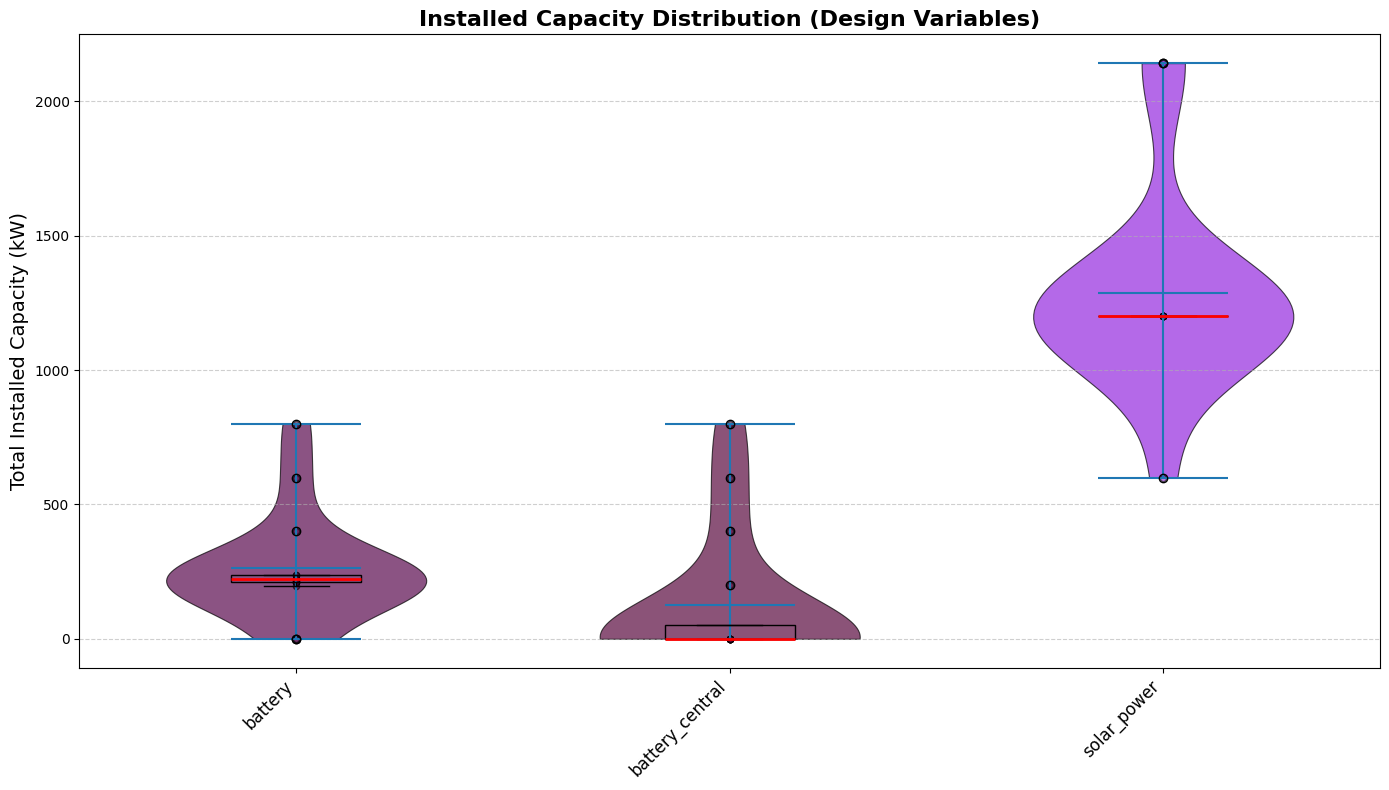

In [19]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Paths and Directories
SCENARIO_DIR = "./sensitivity_analysis_runs_structural_copy"
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist.")

# Visualization Settings
tech_colors = {
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f",
    "solar_power": "#942adf",
    "curtailment": "#b03060",
    "sell_grid_power": "#e6e6dc",
    "supply_grid_power": "#96968c",
    "unmet_demand": "#d62128"
}
design_variables = ["battery", "battery_central", "solar_power"]
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

# Extract Total Flow Cap
def extract_total_flow_cap(directory, variable="flow_cap"):
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    for file in files:
        try:
            model = xr.open_dataset(file)
            
            # Ensure the variable exists
            if variable not in model.variables:
                print(f"[SKIPPED] '{variable}' not found in {file}")
                continue
            
            # Align dimensions to prevent mismatch
            flow_cap = model[variable]
            if "techs" in flow_cap.dims and "nodes" in flow_cap.dims:
                flow_cap = flow_cap.sum(dim="nodes")
                flow_cap_df = flow_cap.to_dataframe(name="total_installed_capacity").reset_index()

                # Align with techs dimension
                if "techs" in model.coords:
                    techs = model["techs"].values
                    flow_cap_df = flow_cap_df[flow_cap_df["techs"].isin(techs)]
                else:
                    print(f"[WARNING] 'techs' coordinate not found in {file}.")
                    continue

                # Append scenario name
                flow_cap_df["scenario"] = os.path.basename(file)
                data.append(flow_cap_df)
            else:
                print(f"[ERROR] '{file}' does not have the required dimensions ('techs', 'nodes').")
        except Exception as e:
            print(f"[ERROR] {file}: {e}")

    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

# Extract Data
df_total = extract_total_flow_cap(SCENARIO_DIR)
if df_total.empty:
    raise ValueError("No valid data found.")

# **Filter out zero capacity values**
df_total = df_total[df_total["total_installed_capacity"] > 0]

# Filter Design and Operational Variables
df_design = df_total[df_total["techs"].isin(design_variables)]
df_operational = df_total[df_total["techs"].isin(operational_variables)]

# Enhanced Violin Plot with Boxplot and Scatter Points
def plot_violin_with_boxplot(data, title, ylabel):
    """
    Enhanced violin plot with overlaid boxplots and scatter points for better truthfulness.
    """
    if data.empty:
        print(f"[WARNING] No data available for {title.lower()}.")
        return

    techs = sorted(data["techs"].unique(), key=lambda x: design_variables.index(x) if x in design_variables else operational_variables.index(x))
    positions = range(len(techs))
    colors = [tech_colors.get(tech, "#cccccc") for tech in techs]

    plt.figure(figsize=(14, 8))

    # Collect data for each tech
    datasets = [data[data["techs"] == tech]["total_installed_capacity"].values for tech in techs]

    # Create violin plots
    violins = plt.violinplot(
        datasets,
        positions=positions,
        showmeans=True,
        showmedians=False,  # We will overlay boxplots for medians
        widths=0.6
    )

    # Custom colors and transparency for violins
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
        body.set_alpha(0.7)
        body.set_edgecolor('black')
        body.set_linewidth(0.8)

    # Overlay boxplots
    for i, dataset in enumerate(datasets):
        plt.boxplot(
            dataset,
            positions=[positions[i]],
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="none", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black")
        )

    # Overlay scatter points
    for i, dataset in enumerate(datasets):
        plt.scatter(
            [positions[i]] * len(dataset),
            dataset,
            color=colors[i],
            alpha=0.6,
            edgecolor="black",
            s=20  # Adjust marker size for better visibility
        )

    # Aesthetics
    plt.xticks(positions, techs, rotation=45, ha="right", fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot Design Variables
plot_violin_with_boxplot(df_design, "Installed Capacity Distribution (Design Variables)", "Total Installed Capacity (kW)")

# Plot Operational Variables
plot_violin_with_boxplot(df_operational, "Installed Capacity Distribution (Operational Variables)", "Total Installed Capacity (kW)")

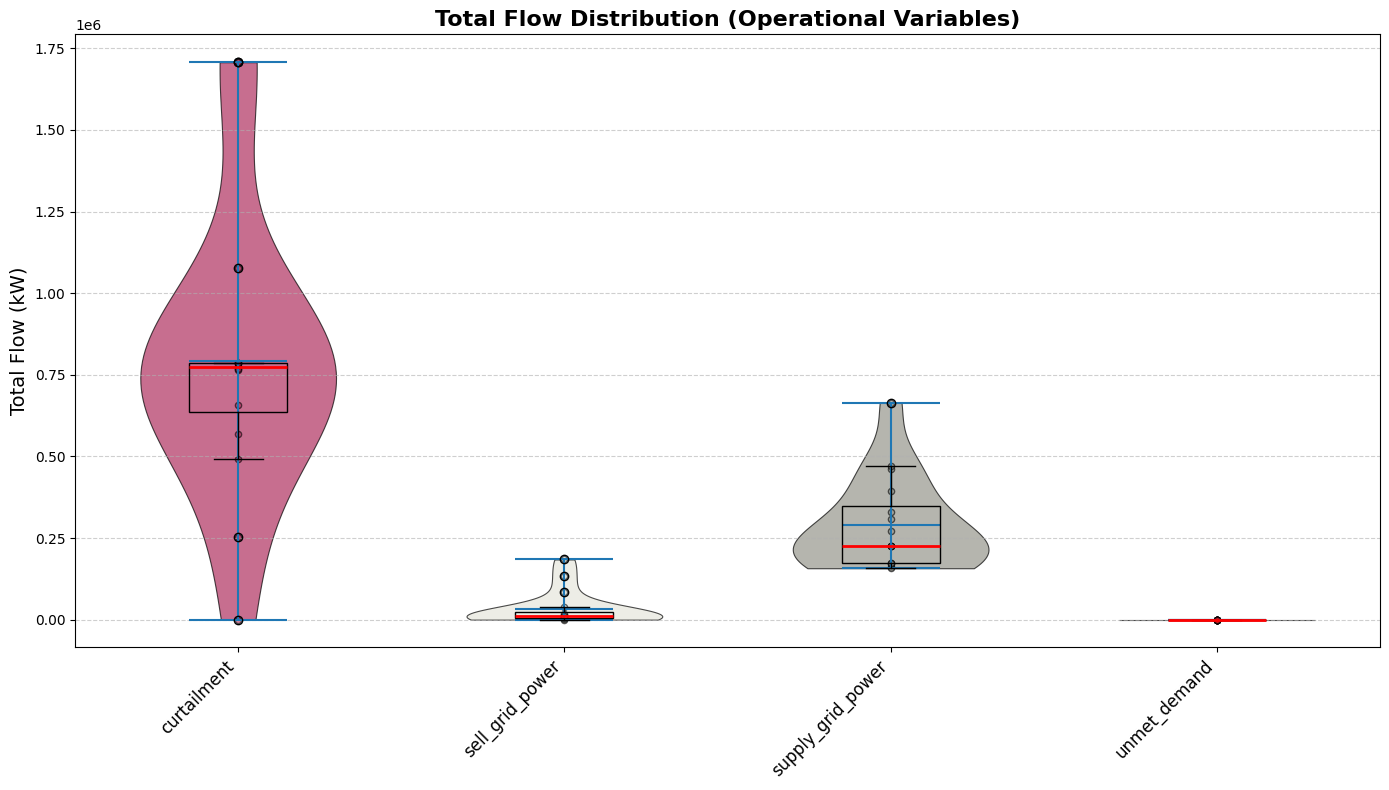

In [27]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Paths and Directories
SCENARIO_DIR = "./sensitivity_analysis_runs_structural_copy"
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Please provide a valid path.")

# Visualization Settings
tech_colors = {
    "curtailment": "#b03060",
    "sell_grid_power": "#e6e6dc",
    "supply_grid_power": "#96968c",
    "unmet_demand": "#d62128"
}
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

def extract_total_flow(directory, techs=None):
    """
    Extract total flow (both in and out) across all nodes and time for each NetCDF file in the directory.
    """
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    if not files:
        raise FileNotFoundError(f"No NetCDF files found in the directory '{directory}'.")

    for file in files:
        try:
            model = xr.open_dataset(file)

            # Filter for specific techs if provided
            if "techs" not in model.dims:
                print(f"[SKIPPED] 'techs' dimension not found in {file}")
                continue

            available_techs = model.coords["techs"].values
            selected_techs = [tech for tech in techs if tech in available_techs] if techs else available_techs

            # Combine flow_in and flow_out
            flow_data = []
            for variable in ["flow_in", "flow_out"]:
                if variable in model.variables:
                    flow = model[variable].sel(techs=selected_techs).sum(dim=["nodes", "timesteps"]).to_dataframe(name=f"total_{variable}").reset_index()
                    flow_data.append(flow)

            # Merge flow_in and flow_out
            if flow_data:
                combined_flow = pd.concat(flow_data, axis=0)
                combined_flow = combined_flow.groupby(["techs"]).sum().reset_index()
                combined_flow["scenario"] = os.path.basename(file)
                data.append(combined_flow)
            else:
                print(f"[WARNING] Neither 'flow_in' nor 'flow_out' found in {file}.")
        except Exception as e:
            print(f"[ERROR] Could not process {file}: {e}")

    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

def plot_violin_with_boxplot(data, title, ylabel, variables, color_map):
    """
    Enhanced violin plot with overlaid boxplots and scatter points.
    """
    if data.empty:
        print(f"[WARNING] No data available for {title.lower()}.")
        return

    techs = variables
    positions = range(len(techs))
    colors = [color_map.get(tech, "#cccccc") for tech in techs]

    plt.figure(figsize=(14, 8))

    # Collect data for each tech, handling missing variables
    datasets = [data[data["techs"] == tech]["total_flow_out"].values if tech in data["techs"].values else [] for tech in techs]

    # Create violin plots
    violins = plt.violinplot(
        datasets,
        positions=positions,
        showmeans=True,
        showmedians=False,  # Overlaid boxplots will handle medians
        widths=0.6
    )

    # Apply custom colors to violins
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
        body.set_alpha(0.7)
        body.set_edgecolor('black')
        body.set_linewidth(0.8)

    # Overlay boxplots
    for i, dataset in enumerate(datasets):
        if len(dataset) > 0:  # Only plot boxplot if there is data
            plt.boxplot(
                dataset,
                positions=[positions[i]],
                widths=0.3,
                patch_artist=True,
                boxprops=dict(facecolor="none", color="black"),
                medianprops=dict(color="red", linewidth=2),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black")
            )

    # Overlay scatter points
    for i, dataset in enumerate(datasets):
        if len(dataset) > 0:  # Only plot scatter points if there is data
            plt.scatter(
                [positions[i]] * len(dataset),
                dataset,
                color=colors[i],
                alpha=0.6,
                edgecolor="black",
                s=20  # Adjust marker size for better visibility
            )

    # Aesthetics
    plt.xticks(positions, techs, rotation=45, ha="right", fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Main Execution
try:
    # Extract Data for Operational Variables
    df_total = extract_total_flow(SCENARIO_DIR, techs=operational_variables)
    if df_total.empty:
        raise ValueError("No valid data found.")

    # Ensure total flow column combines both in and out flows
    df_total["total_flow_out"] = df_total.filter(like="total_").sum(axis=1)

    # Plot Operational Variables
    plot_violin_with_boxplot(
        df_total,
        "Total Flow Distribution (Operational Variables)",
        "Total Flow (kW)",
        operational_variables,
        tech_colors
    )

except Exception as e:
    print(f"[ERROR] {e}")

In [28]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_curtailment_ratio(directory):
    """
    Calculate the curtailment ratio as the total curtailment flow divided by the total solar power flow
    over all timesteps and nodes for each scenario in the directory.
    """
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    if not files:
        raise FileNotFoundError(f"No NetCDF files found in the directory '{directory}'.")

    for file in files:
        try:
            model = xr.open_dataset(file)

            # Ensure both variables exist
            if "flow_out" not in model.variables or "flow_in" not in model.variables:
                print(f"[SKIPPED] Missing 'flow_out' or 'flow_in' in {file}")
                continue

            # Filter for curtailment and solar_power techs
            techs = model.coords["techs"].values
            if "curtailment" not in techs or "solar_power" not in techs:
                print(f"[SKIPPED] Missing 'curtailment' or 'solar_power' techs in {file}")
                continue

            # Calculate total flows for curtailment and solar_power
            curtailment_flow = model["flow_out"].sel(techs="curtailment").sum(dim=["nodes", "timesteps"]).values
            solar_power_flow = (
                model["flow_out"].sel(techs="solar_power").sum(dim=["nodes", "timesteps"]).values +
                model["flow_in"].sel(techs="solar_power").sum(dim=["nodes", "timesteps"]).values
            )

            # Calculate curtailment ratio
            if solar_power_flow > 0:
                curtailment_ratio = curtailment_flow / solar_power_flow
            else:
                curtailment_ratio = np.nan  # Avoid division by zero

            # Append results
            data.append({"scenario": os.path.basename(file), "curtailment_ratio": curtailment_ratio})

        except Exception as e:
            print(f"[ERROR] Could not process {file}: {e}")

    return pd.DataFrame(data)

def plot_curtailment_ratio_variance(df, title="Curtailment Ratio Variance"):
    """
    Plot the variance of the curtailment ratio across scenarios.
    """
    if df.empty:
        print("[WARNING] No data available for plotting.")
        return

    plt.figure(figsize=(10, 6))
    plt.bar(df["scenario"], df["curtailment_ratio"], color="#b03060", alpha=0.8, edgecolor="black")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.ylabel("Curtailment Ratio", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example Execution
# Replace 'SCENARIO_DIR' with the path to your NetCDF files
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"

try:
    # Calculate Curtailment Ratios
    df_curtailment_ratios = calculate_curtailment_ratio(SCENARIO_DIR)
    if df_curtailment_ratios.empty:
        raise ValueError("No valid data found for curtailment ratio calculation.")

    # Plot Variance of Curtailment Ratios
    plot_curtailment_ratio_variance(df_curtailment_ratios)

except Exception as e:
    print(f"[ERROR] {e}")

[ERROR] Could not process ./sensitivity_analysis_runs_parameter/sensitivity_transformer_size_1200.nc: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
[ERROR] Could not process ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s0_27.nc: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
[ERROR] Could not process ./sensitivity_analysis_runs_parameter/sensitivity_sustainable.nc: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
[SKIPPED] Missing 'flow_out' or 'flow_in' in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc
[SKIPPED] Missing 'flow_out' or 'flow_in' in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc
[ERROR] Could not process ./sensitivity_analysis_runs_parameter/sensitivity_battery_price_100.nc: The truth value of an array with more than one elem

In [3]:
print(df_combined[df_combined["installed_capacity"] < 0])

Empty DataFrame
Columns: [techs, carriers, installed_capacity, scenario]
Index: []


[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc
[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc
[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc


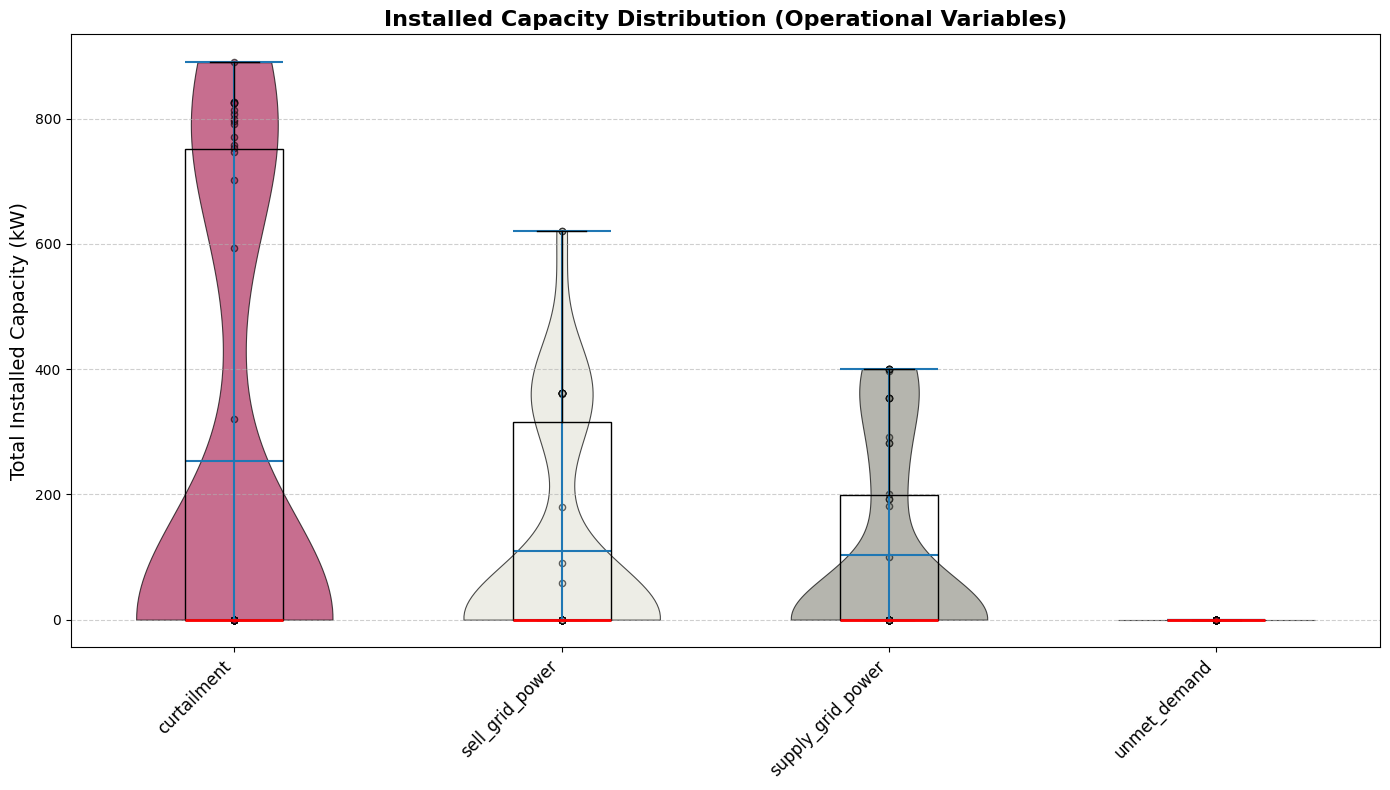

In [17]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Paths and Directories
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist.")

# Visualization Settings
tech_colors = {
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f",
    "solar_power": "#942adf",
    "curtailment": "#b03060",
    "sell_grid_power": "#e6e6dc",
    "supply_grid_power": "#96968c",
    "unmet_demand": "#d62128"
}
design_variables = ["battery", "battery_central", "solar_power"]
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

# Extract Total Flow Cap
def extract_total_flow_cap(directory, variable="flow_cap"):
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    for file in files:
        try:
            model = xr.open_dataset(file)
            
            # Ensure the variable exists
            if variable not in model.variables:
                print(f"[SKIPPED] '{variable}' not found in {file}")
                continue
            
            # Align dimensions to prevent mismatch
            flow_cap = model[variable]
            if "techs" in flow_cap.dims and "nodes" in flow_cap.dims:
                flow_cap = flow_cap.sum(dim="nodes")
                flow_cap_df = flow_cap.to_dataframe(name="total_installed_capacity").reset_index()

                # Align with techs dimension
                if "techs" in model.coords:
                    techs = model["techs"].values
                    flow_cap_df = flow_cap_df[flow_cap_df["techs"].isin(techs)]
                else:
                    print(f"[WARNING] 'techs' coordinate not found in {file}.")
                    continue

                # Append scenario name
                flow_cap_df["scenario"] = os.path.basename(file)
                data.append(flow_cap_df)
            else:
                print(f"[ERROR] '{file}' does not have the required dimensions ('techs', 'nodes').")
        except Exception as e:
            print(f"[ERROR] {file}: {e}")

    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

# Extract Data
df_total = extract_total_flow_cap(SCENARIO_DIR)
if df_total.empty:
    raise ValueError("No valid data found.")

# Filter Design and Operational Variables
df_design = df_total[df_total["techs"].isin(design_variables)]
df_operational = df_total[df_total["techs"].isin(operational_variables)]

# Enhanced Violin Plot with Boxplot and Scatter Points
def plot_violin_with_boxplot(data, title, ylabel):
    """
    Enhanced violin plot with overlaid boxplots and scatter points for better truthfulness.
    """
    if data.empty:
        print(f"[WARNING] No data available for {title.lower()}.")
        return

    techs = sorted(data["techs"].unique(), key=lambda x: design_variables.index(x) if x in design_variables else operational_variables.index(x))
    positions = range(len(techs))
    colors = [tech_colors.get(tech, "#cccccc") for tech in techs]

    plt.figure(figsize=(14, 8))

    # Collect data for each tech
    datasets = [data[data["techs"] == tech]["total_installed_capacity"].values for tech in techs]

    # Create violin plots
    violins = plt.violinplot(
        datasets,
        positions=positions,
        showmeans=True,
        showmedians=False,  # We will overlay boxplots for medians
        widths=0.6
    )

    # Custom colors and transparency for violins
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
        body.set_alpha(0.7)
        body.set_edgecolor('black')
        body.set_linewidth(0.8)

    # Overlay boxplots
    for i, dataset in enumerate(datasets):
        plt.boxplot(
            dataset,
            positions=[positions[i]],
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="none", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black")
        )

    # Overlay scatter points
    for i, dataset in enumerate(datasets):
        plt.scatter(
            [positions[i]] * len(dataset),
            dataset,
            color=colors[i],
            alpha=0.6,
            edgecolor="black",
            s=20  # Adjust marker size for better visibility
        )

    # Aesthetics
    plt.xticks(positions, techs, rotation=45, ha="right", fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot Design Variables
plot_violin_with_boxplot(df_design, "Installed Capacity Distribution (Design Variables)", "Total Installed Capacity (kW)")

# Plot Operational Variables
plot_violin_with_boxplot(df_operational, "Installed Capacity Distribution (Operational Variables)", "Total Installed Capacity (kW)")

[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc
[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc
[SKIPPED] 'flow_cap' not found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc


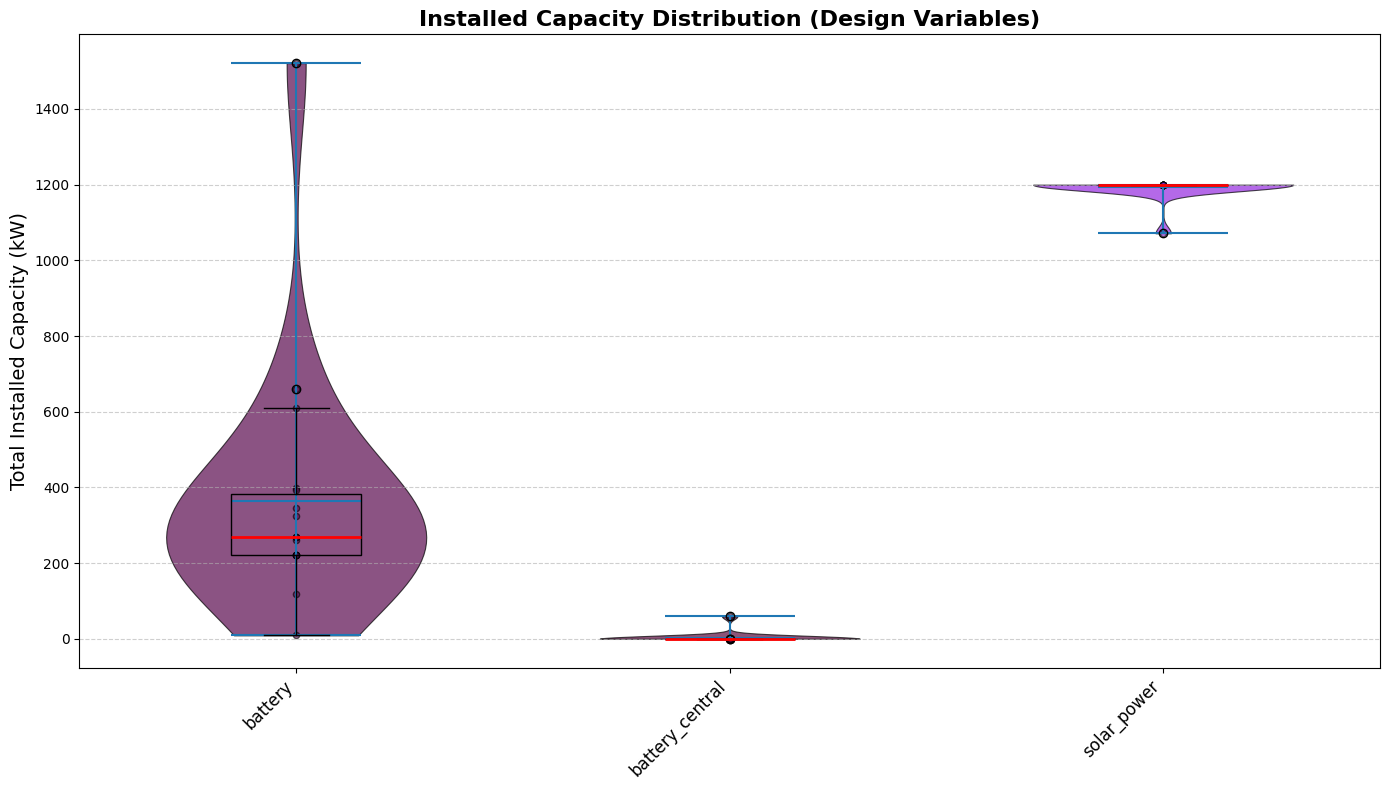

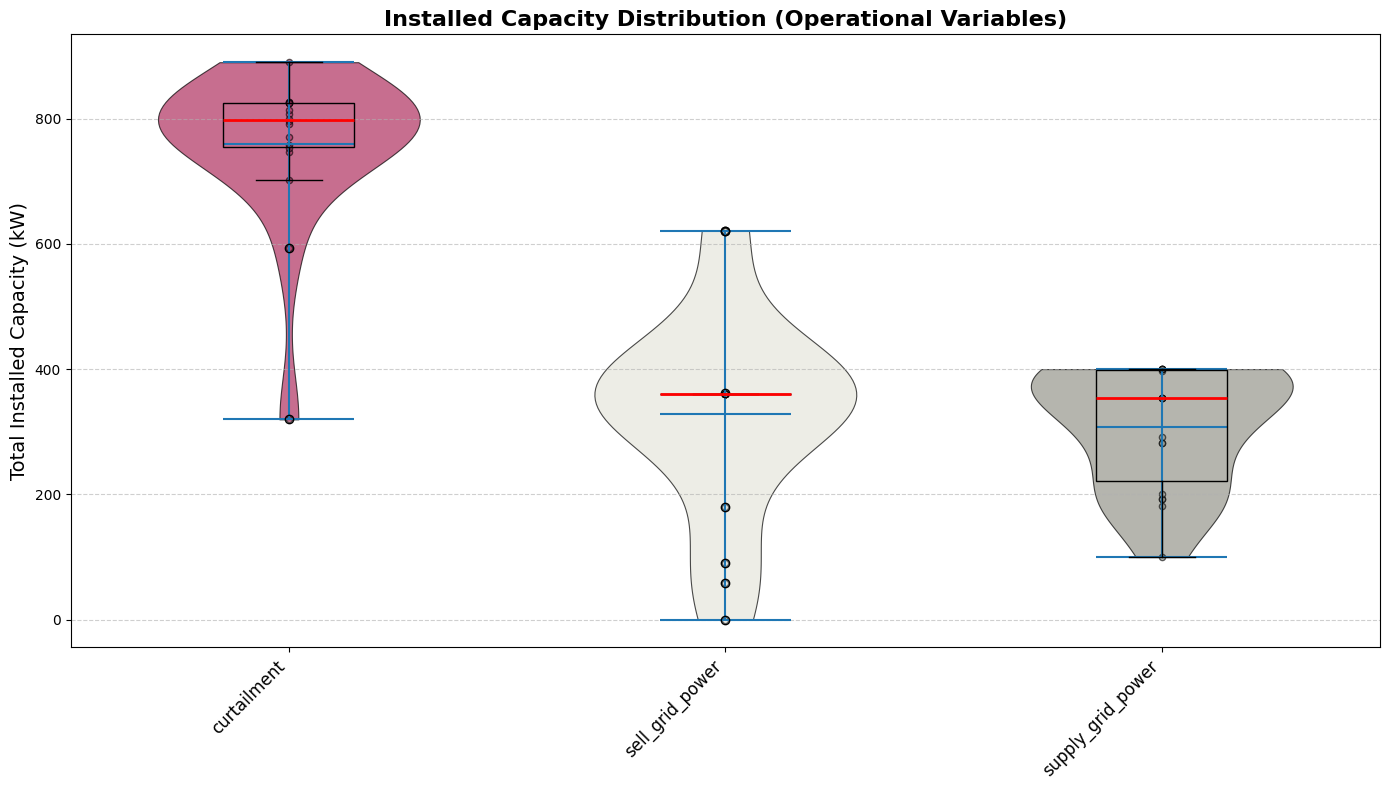

In [18]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Paths and Directories
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist.")

# Visualization Settings
tech_colors = {
    "battery": "#5a0a4f",
    "battery_central": "#5a0a3f",
    "solar_power": "#942adf",
    "curtailment": "#b03060",
    "sell_grid_power": "#e6e6dc",
    "supply_grid_power": "#96968c",
    "unmet_demand": "#d62128"
}
design_variables = ["battery", "battery_central", "solar_power"]
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

# Extract Total Flow Cap
def extract_total_flow_cap(directory, variable="flow_cap"):
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    for file in files:
        try:
            model = xr.open_dataset(file)
            
            # Ensure the variable exists
            if variable not in model.variables:
                print(f"[SKIPPED] '{variable}' not found in {file}")
                continue
            
            # Align dimensions to prevent mismatch
            flow_cap = model[variable]
            if "techs" in flow_cap.dims and "nodes" in flow_cap.dims:
                flow_cap = flow_cap.sum(dim="nodes")
                flow_cap_df = flow_cap.to_dataframe(name="total_installed_capacity").reset_index()

                # Align with techs dimension
                if "techs" in model.coords:
                    techs = model["techs"].values
                    flow_cap_df = flow_cap_df[flow_cap_df["techs"].isin(techs)]
                else:
                    print(f"[WARNING] 'techs' coordinate not found in {file}.")
                    continue

                # Append scenario name
                flow_cap_df["scenario"] = os.path.basename(file)
                data.append(flow_cap_df)
            else:
                print(f"[ERROR] '{file}' does not have the required dimensions ('techs', 'nodes').")
        except Exception as e:
            print(f"[ERROR] {file}: {e}")

    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

# Extract Data
df_total = extract_total_flow_cap(SCENARIO_DIR)
if df_total.empty:
    raise ValueError("No valid data found.")

# **Filter out zero capacity values**
df_total = df_total[df_total["total_installed_capacity"] > 0]

# Filter Design and Operational Variables
df_design = df_total[df_total["techs"].isin(design_variables)]
df_operational = df_total[df_total["techs"].isin(operational_variables)]

# Enhanced Violin Plot with Boxplot and Scatter Points
def plot_violin_with_boxplot(data, title, ylabel):
    """
    Enhanced violin plot with overlaid boxplots and scatter points for better truthfulness.
    """
    if data.empty:
        print(f"[WARNING] No data available for {title.lower()}.")
        return

    techs = sorted(data["techs"].unique(), key=lambda x: design_variables.index(x) if x in design_variables else operational_variables.index(x))
    positions = range(len(techs))
    colors = [tech_colors.get(tech, "#cccccc") for tech in techs]

    plt.figure(figsize=(14, 8))

    # Collect data for each tech
    datasets = [data[data["techs"] == tech]["total_installed_capacity"].values for tech in techs]

    # Create violin plots
    violins = plt.violinplot(
        datasets,
        positions=positions,
        showmeans=True,
        showmedians=False,  # We will overlay boxplots for medians
        widths=0.6
    )

    # Custom colors and transparency for violins
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
        body.set_alpha(0.7)
        body.set_edgecolor('black')
        body.set_linewidth(0.8)

    # Overlay boxplots
    for i, dataset in enumerate(datasets):
        plt.boxplot(
            dataset,
            positions=[positions[i]],
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="none", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black")
        )

    # Overlay scatter points
    for i, dataset in enumerate(datasets):
        plt.scatter(
            [positions[i]] * len(dataset),
            dataset,
            color=colors[i],
            alpha=0.6,
            edgecolor="black",
            s=20  # Adjust marker size for better visibility
        )

    # Aesthetics
    plt.xticks(positions, techs, rotation=45, ha="right", fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot Design Variables
plot_violin_with_boxplot(df_design, "Installed Capacity Distribution (Design Variables)", "Total Installed Capacity (kW)")

# Plot Operational Variables
plot_violin_with_boxplot(df_operational, "Installed Capacity Distribution (Operational Variables)", "Total Installed Capacity (kW)")

In [26]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Paths and Directories
SCENARIO_DIR = "./sensitivity_analysis_runs_parameter"
if not os.path.exists(SCENARIO_DIR):
    raise FileNotFoundError(f"The directory '{SCENARIO_DIR}' does not exist. Please provide a valid path.")

# Visualization Settings
tech_colors = {
    "curtailment": "#b03060",
    "sell_grid_power": "#e6e6dc",
    "supply_grid_power": "#96968c",
    "unmet_demand": "#d62128"
}
operational_variables = ["curtailment", "sell_grid_power", "supply_grid_power", "unmet_demand"]

def extract_total_flow(directory, techs=None):
    """
    Extract total flow (both in and out) across all nodes and time for each NetCDF file in the directory.
    """
    data = []
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".nc")]

    if not files:
        raise FileNotFoundError(f"No NetCDF files found in the directory '{directory}'.")

    for file in files:
        try:
            model = xr.open_dataset(file)

            # Filter for specific techs if provided
            if "techs" not in model.dims:
                print(f"[SKIPPED] 'techs' dimension not found in {file}")
                continue

            available_techs = model.coords["techs"].values
            selected_techs = [tech for tech in techs if tech in available_techs] if techs else available_techs

            # Combine flow_in and flow_out
            flow_data = []
            for variable in ["flow_in", "flow_out"]:
                if variable in model.variables:
                    flow = model[variable].sel(techs=selected_techs).sum(dim=["nodes", "timesteps"]).to_dataframe(name=f"total_{variable}").reset_index()
                    flow_data.append(flow)

            # Merge flow_in and flow_out
            if flow_data:
                combined_flow = pd.concat(flow_data, axis=0)
                combined_flow = combined_flow.groupby(["techs"]).sum().reset_index()
                combined_flow["scenario"] = os.path.basename(file)
                data.append(combined_flow)
            else:
                print(f"[WARNING] Neither 'flow_in' nor 'flow_out' found in {file}.")
        except Exception as e:
            print(f"[ERROR] Could not process {file}: {e}")

    return pd.concat(data, ignore_index=True) if data else pd.DataFrame()

def plot_violin_with_boxplot(data, title, ylabel, variables, color_map):
    """
    Enhanced violin plot with overlaid boxplots and scatter points.
    """
    if data.empty:
        print(f"[WARNING] No data available for {title.lower()}.")
        return

    techs = variables
    positions = range(len(techs))
    colors = [color_map.get(tech, "#cccccc") for tech in techs]

    plt.figure(figsize=(14, 8))

    # Collect data for each tech, handling missing variables
    datasets = [data[data["techs"] == tech]["total_flow_out"].values if tech in data["techs"].values else [] for tech in techs]

    # Create violin plots
    violins = plt.violinplot(
        datasets,
        positions=positions,
        showmeans=True,
        showmedians=False,  # Overlaid boxplots will handle medians
        widths=0.6
    )

    # Apply custom colors to violins
    for i, body in enumerate(violins['bodies']):
        body.set_facecolor(colors[i])
        body.set_alpha(0.7)
        body.set_edgecolor('black')
        body.set_linewidth(0.8)

    # Overlay boxplots
    for i, dataset in enumerate(datasets):
        if len(dataset) > 0:  # Only plot boxplot if there is data
            plt.boxplot(
                dataset,
                positions=[positions[i]],
                widths=0.3,
                patch_artist=True,
                boxprops=dict(facecolor="none", color="black"),
                medianprops=dict(color="red", linewidth=2),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black")
            )

    # Overlay scatter points
    for i, dataset in enumerate(datasets):
        if len(dataset) > 0:  # Only plot scatter points if there is data
            plt.scatter(
                [positions[i]] * len(dataset),
                dataset,
                color=colors[i],
                alpha=0.6,
                edgecolor="black",
                s=20  # Adjust marker size for better visibility
            )

    # Aesthetics
    plt.xticks(positions, techs, rotation=45, ha="right", fontsize=12)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Main Execution
try:
    # Extract Data for Operational Variables
    df_total = extract_total_flow(SCENARIO_DIR, techs=operational_variables)
    if df_total.empty:
        raise ValueError("No valid data found.")

    # Ensure total flow column combines both in and out flows
    df_total["total_flow_out"] = df_total.filter(like="total_").sum(axis=1)

    # Plot Operational Variables
    plot_violin_with_boxplot(
        df_total,
        "Total Flow Distribution (Operational Variables)",
        "Total Flow (kW)",
        operational_variables,
        tech_colors
    )

except Exception as e:
    print(f"[ERROR] {e}")

[WARNING] Neither 'flow_in' nor 'flow_out' found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_13.nc.
[WARNING] Neither 'flow_in' nor 'flow_out' found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b_day_ahead_s0_03.nc.
[WARNING] Neither 'flow_in' nor 'flow_out' found in ./sensitivity_analysis_runs_parameter/sensitivity_price_fixed_retail_b0_27_s_day_ahead.nc.
